In [1]:
import numpy as np
import matplotlib.pyplot as plt 

In [52]:
# DEFINITIONS

# Eulerian Grid for [-1, 1]²
N_fluid = 500
xx = np.linspace (-2.0, 2.0, N_fluid)
fluid_grid_x, fluid_grid_y = np.meshgrid(xx, xx)
del (xx)
# Lagrangian Grid for ellipse: {r = 0.5}
N_solid = 60
r_solid = 0.5
ss = np.linspace (0., 1., N_solid, endpoint = False)
solid_grid_x = r_solid*np.cos(2*np.pi*ss)
solid_grid_y = r_solid*np.sin(2*np.pi*ss)
normal_x = solid_grid_x/r_solid
normal_y = solid_grid_y/r_solid
#normal_x = r_solid*np.cos(2*np.pi*ss)/np.sqrt(r_solid**2*(4*np.sin(2*np.pi*ss)**2+ np.cos(2*np.pi*ss)**2))
#normal_y = 2*r_solid*np.sin(2*np.pi*ss)/np.sqrt(r_solid**2*(4*np.sin(2*np.pi*ss)**2 + np.cos(2*np.pi*ss)**2))

# Electrostatic Potential (arbitrary radial field)
def phi (x):
    # x is an array with shape (2,)
    theta_abs = np.arctan(x[1]/x[0])
    theta = theta_abs*int(x[0]>0) + (np.pi+theta_abs)*int(x[0]<0)
    return np.linalg.norm(x)

# Window Function (support on cone {r :[0,h], theta: [theta_0, pi-theta_0]})
def delta_h (x, n, h, theta_0):
    # x and n are arrays with shape (2,)
    # h is the radius of the support
    r = np.linalg.norm(x)
    tau = np.dot(np.array([[0,-1],[1,0]]), n) #tangent to surface
    first_quadrant = int(np.dot(x,tau)>0)
    theta_abs =np.arccos(np.sqrt(1- (np.dot(x,n)/r)**2))
    theta = theta_abs*first_quadrant+(np.pi-theta_abs)*(1-first_quadrant)
    r_star = r/h
    theta_star = (theta - theta_0)*np.pi/(np.pi-2*theta_0)
    indicator_cone = int(r<h and theta>theta_0 and theta<(np.pi-theta_0) and np.dot(x,n)<0)
    return -np.pi/(h**3*np.cos(theta_0))*np.sin(2*np.pi*r_star)*indicator_cone
    #return -np.pi**2/(np.cos(theta_0)*h**3)*np.cos(2*np.pi*r_star)*indicator_cone
    
def delta_h_circle (x, n, h):
    # window function with circuar support 
    # x and n are arrays with shape (2,)
    # h is the radius of the support
    r = np.linalg.norm(x)
    tau = np.dot(np.array([[0,-1],[1,0]]), n) #tangent to surface
    first_quadrant = int(np.dot(x,tau)>0)
    theta_abs =np.arccos(np.sqrt(1- (np.dot(x,n)/r)**2))
    theta = theta_abs*first_quadrant+(np.pi-theta_abs)*(1-first_quadrant)
    r_star = r/h
    theta_star = (theta - theta_0)*np.pi/(np.pi-2*theta_0)
    indicator_cone = int(r<h)
    return -2/h**2*np.sin(2*np.pi*r_star)*np.sin(theta)*indicator_cone

# Original Window Function (by Peskin) (to check)
def f(r):
    return  1/4*(1+np.cos(0.5*np.pi*r))*int(np.abs(r)<2)
def delta_h_orig (x, h):
    return 1/h**2*f(x[0]/h)*f(x[1]/h)

# Window Function by Roma 
def f_roma (r):
    if (np.abs(r)<0.5):
        return 1/3*(1+np.sqrt(1-3*r**2))
    elif (np.abs(r)<1.5):
        return 1/6*(5-3*np.abs(r) -np.sqrt(1-3*(1-np.abs(r))**2))
    else:
        return 0. 

def delta_h_roma (x, h):
    return 1/h**2*f_roma(x[0]/h)*f_roma(x[1]/h)

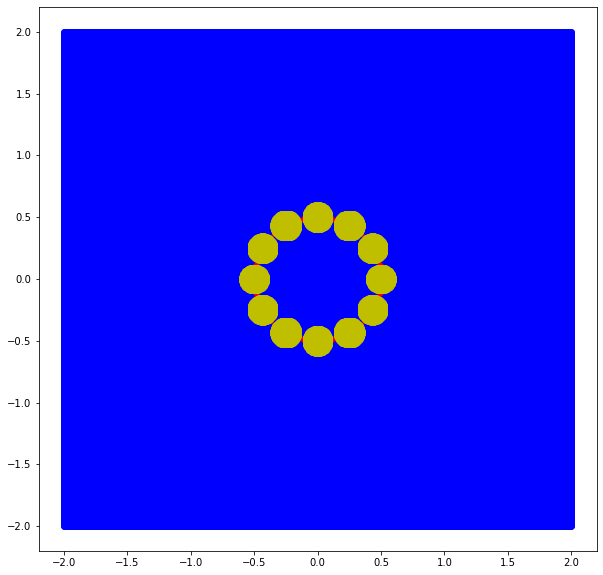

In [53]:
# VISUALIZE GRIDS
fig, ax = plt.subplots(figsize = (10,10))
f1 = ax.plot(np.reshape(fluid_grid_x, N_fluid*N_fluid), np.reshape(fluid_grid_y, N_fluid*N_fluid), 'bo')
f2 = ax.plot(solid_grid_x, solid_grid_y, 'ro')

# INTERPOLATE E ON SOLID GRID (with visualization of support)
h = 0.1             #reasonably, I should take a radius comparable with the fluid grid spacing 
theta_0 = np.pi/2.5      #the angle span should be chosen in a way to be sure of keeping inside the circle
                       #the max angle is of the order of h/R
Vol = (4/N_fluid)**2
E_normal = np.zeros(N_solid)
Phi_solid = np.zeros(N_solid)
for k in range (N_solid):
    x0 = np.array((solid_grid_x[k], solid_grid_y[k]))
    n = np.array((normal_x[k], normal_y[k]))
    for i in range (N_fluid):
        for j in range(N_fluid):
            x = np.array((fluid_grid_x[i,j], fluid_grid_y[i,j]))
            if (k%5==0):
                if (np.abs(delta_h_circle (x-x0, n, h))>1e-5 ):
                #if (np.abs(delta_h_orig (x-x0, h))>1e-5 ):
                    #mark in yellow fluid grids in the support
                    f3 = ax.plot (fluid_grid_x[i,j],fluid_grid_y[i,j], 'yo')
            E_normal[k] = E_normal[k] + delta_h_circle (x-x0, n, h)*phi(x)*Vol
            Phi_solid[k] = Phi_solid[k] + delta_h_roma (x-x0, h)*phi(x)*Vol

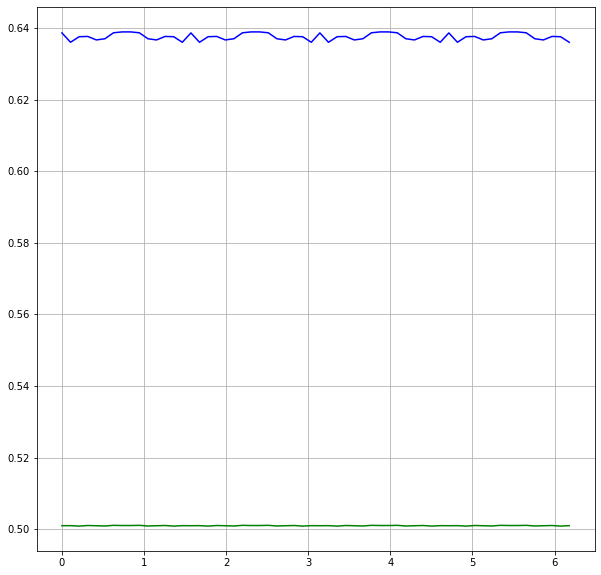

In [54]:
# VISUALIZATION
fig, ax = plt.subplots(figsize = (10,10))
#f1 = ax.plot (2*np.pi*ss, np.ones(N_solid)*0.25, 'r-') 
f2 = ax.plot (2*np.pi*ss, E_normal, 'b-')
f3 = ax.plot (2*np.pi*ss, Phi_solid, 'g-')
ax.grid()

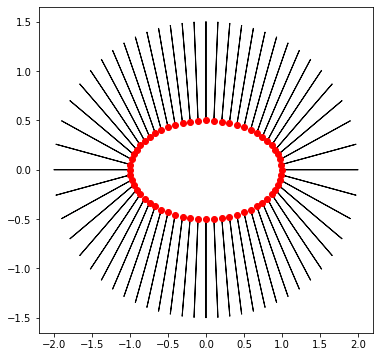

In [51]:
# VISUALIZATION
fig, ax = plt.subplots(figsize = (6,6))
for k in range (N_solid):
        ax.plot (solid_grid_x[k],solid_grid_y[k], 'ro')
        n = np.array([normal_x[k], normal_y[k]])
        tau = np.dot(np.array([[0,-1],[1,0]]), n)
        ax.arrow (solid_grid_x[k],solid_grid_y[k], normal_x[k], normal_y[k])

-0.03115031635180977


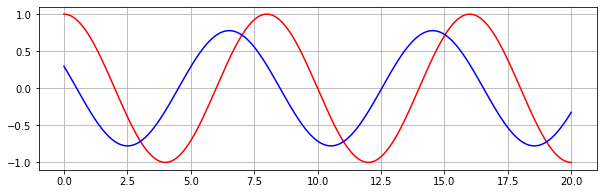

In [387]:
# MONODIMENSIONAL CASE 
h_filter = 1
N = 400
M = 200
h_grid = 20/N
f = lambda x: np.cos(0.25*x*np.pi)
xx = np.linspace(0,20, N)
psi = lambda t: (-2*np.pi/h_filter**2)*np.sin(2*np.pi*t/h_filter)*int(t<0 and t>-h_filter)

ff = f(xx)
f_prime = np.zeros(N)
for k in range(N):
    h_integ = h_filter/M
    x = k*h_grid
    for j in range (M):
        # use a proper quadrature formula (Simpson) 
        f_prime [k] = f_prime [k]+ h_integ*psi(-h_integ*j)*f(x-h_integ*j)
fig, ax = plt.subplots(figsize=(10,3))
f1 = ax.plot (xx, ff, 'r')
f2 = ax.plot (xx, f_prime, 'b')
ax.grid()
print ((f_prime[-1]-f_prime[0])/20)